# Background

This competition involves building a model to classify tweets as describing real disasters or not. The dataset contains 10,000 hand-labeled tweets, with each tweet labeled as disaster-related (1) or not (0). The objective is to predict the labels for unseen tweets. Model performance will be evaluated using the F1 score, which balances precision and recall.

Columns:

id - a unique identifier for each tweet

text - the text of the tweet

location - the location the tweet was sent from (may be blank)

keyword - a particular keyword from the tweet (may be blank)

target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)


In [1]:
import numpy as np
import pandas as pd
import keras


# Data loading & EDA

In [2]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
train_df.shape

(7613, 5)

We have 7613 columns in the training set, and 5 columns

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_df['keyword'].isna().sum()

61

61 Records are missing the 'keyword' field

In [5]:
train_df['location'].isna().sum()

2533

2533 records missing 'location' field

Let's examine the class balance:

<Axes: >

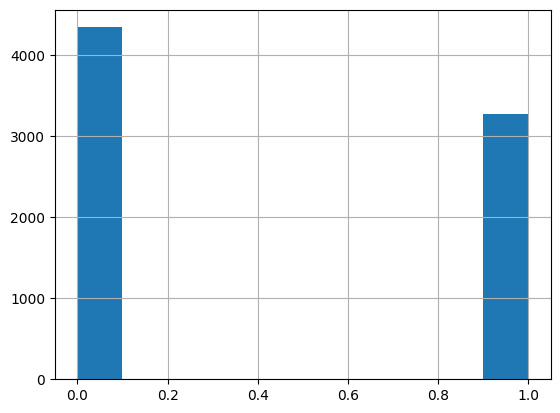

In [6]:
train_df['target'].hist()

There are slightly more records in the 0 class

In [7]:
train_df['keyword'].value_counts().head(20)

keyword
fatalities     45
armageddon     42
deluge         42
harm           41
damage         41
sinking        41
body%20bags    41
siren          40
windstorm      40
twister        40
outbreak       40
collided       40
fear           40
evacuate       40
wrecked        39
hellfire       39
explosion      39
derailment     39
collision      39
weapons        39
Name: count, dtype: int64

The top keywords seem to be disaster related words

<Axes: >

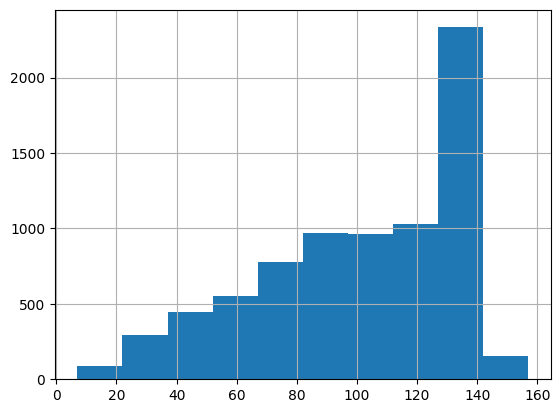

In [8]:
train_df['text'].apply(len).hist()

Examining the tweets lengths, it looks like many of the tweets utilized the max length (at the time) of 140 characters.
In addition, there seem to be a few outlier records above the max length, let's examine what's in there:

In [9]:
train_df[train_df['text'].apply(len)>140]['text'].sample(1).values

array(['Maailiss: Diaporama : sixpenceee: Karymsky Lake is a crater lake located in the Karymsky volcanoåÊinåÊRussia. With a\x89Û_ http://t.co/4o460Fm8HN'],
      dtype=object)

It looks like the character limit did not really go over the max, but the html escaping of the data converting '&' into '&amp;' make it appear like it did

It also mean we should html unescape the text field as a preprocessing stage, in order to clean the text.

In [10]:
import html
train_df['text'] = train_df['text'].apply(html.unescape)

# Architecture

## The model layers

Embedding Layer: This layer turns the text into dense vectors, where each word is represented by a fixed-size vector.
It helps the model understand the meaning of words in relation to each other.

GRU Layer: This layer processes the sequence of words.
GRUs are a type of RNN that helps the model remember information from earlier words, which is important for understanding the full meaning of a sentence.

Dropout Layer: This layer randomly drops some connections during training to prevent the model from overfitting, meaning it won’t just memorize the training data but will learn to generalize better.

Dense Layer with Sigmoid Activation: This is the output layer that gives a prediction—whether the tweet is about a disaster (1) or not (0).

## Reasoning

Text is Sequential: GRU works well because text has an order (words follow each other), and we need to understand that order to get the meaning.

Efficiency: GRU is faster than other types of RNNs like LSTM, so it’s a good choice when we want a balance of performance and speed.

Avoid Overfitting: The dropout layer helps the model not to memorize the data, but rather learn general patterns that work on new data.

## Text Representation

To turn the raw text into a form the model can understand, I used a tokenizer.

It converts words into numbers based on their frequency in the dataset.

Then, I applied padding to make sure all the input sequences have the same length, so the model can process them in batches.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Embedding, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam


In [12]:
# Parameters
max_vocab = 10000   # Maximum vocabulary size
embedding_dim = 50  # Dimension of the embedding vector
batch_size = 32     # Batch size for training
epochs = 20         # Number of epochs

In [13]:
# Preprocessing text data
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(train_df['text'])
X = tokenizer.texts_to_sequences(train_df['text'])
X = pad_sequences(X)

y = train_df['target'].values

In [14]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Building the model
def build_model(gru_units, dropout, lr):
    model = Sequential()
    model.add(Embedding(input_dim=max_vocab, output_dim=embedding_dim))
    model.add(GRU(gru_units, return_sequences=False))  # GRU layer
    model.add(Dropout(dropout))  # Dropout to prevent overfitting
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output layer

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [16]:
models = [
    build_model(64, 0.1, 5e-5),
    build_model(64, 0.3, 5e-5),
    build_model(64, 0.5, 5e-5),
]

checkpoint_cb = [keras.callbacks.ModelCheckpoint(f"tweeter_model_{n}.keras", save_best_only=True) for n in range(len(models))]

early_stopping_cb = [keras.callbacks.EarlyStopping(
    patience=3, restore_best_weights=True
) for n in range(len(models))]


In [17]:
def train_multiple_models(models):
    best_model = None
    best_accuracy = 0
    
    histories = []
    
    for n, model in enumerate(models):
        # Train the model
        history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[checkpoint_cb[n], early_stopping_cb[n]])
        histories.append(history)
        
        # Evaluate the model
        loss, accuracy = model.evaluate(X_test, y_test)
        print(f"Test Accuracy: {accuracy:.4f}")
    
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
    
    return histories, best_accuracy, best_model

In [18]:
histories, best_accuracy, best_model = train_multiple_models(models)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5291 - loss: 0.6912 - val_accuracy: 0.5739 - val_loss: 0.6832
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5780 - loss: 0.6777 - val_accuracy: 0.5778 - val_loss: 0.6594
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5883 - loss: 0.6520 - val_accuracy: 0.6389 - val_loss: 0.6313
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6637 - loss: 0.6257 - val_accuracy: 0.6651 - val_loss: 0.6143
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6999 - loss: 0.5810 - val_accuracy: 0.6881 - val_loss: 0.5897
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7359 - loss: 0.5456 - val_accuracy: 0.7347 - val_loss: 0.5464
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7936 - loss: 0.4654 - val_accuracy: 0.7774 - val_loss: 0.5011
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8330 - loss: 0.4036 - val_accuracy: 0.

In [19]:
import matplotlib.pyplot as plt

def plot_histories(histories):
    for history in histories:
        # Plotting training and validation loss
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [20]:
print(best_accuracy)

0.8082731366157532


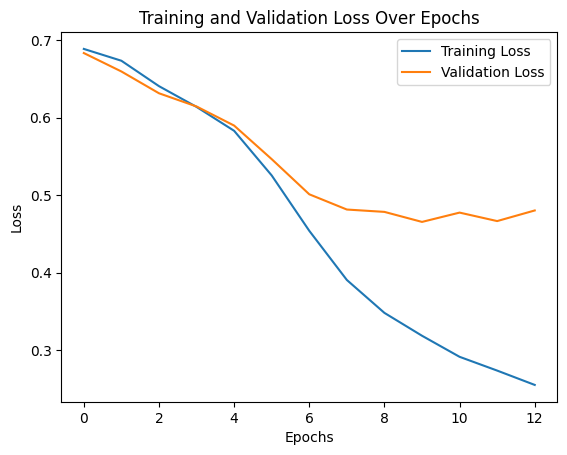

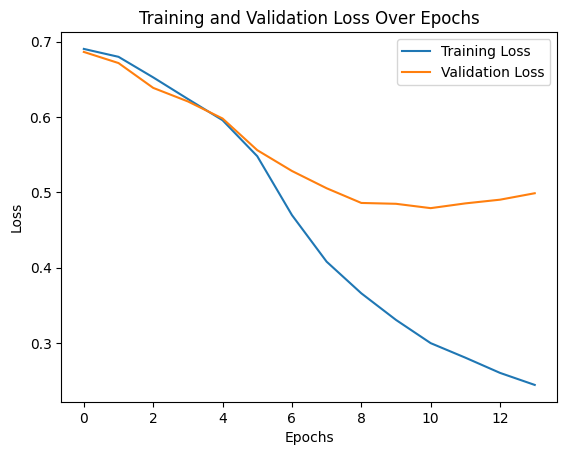

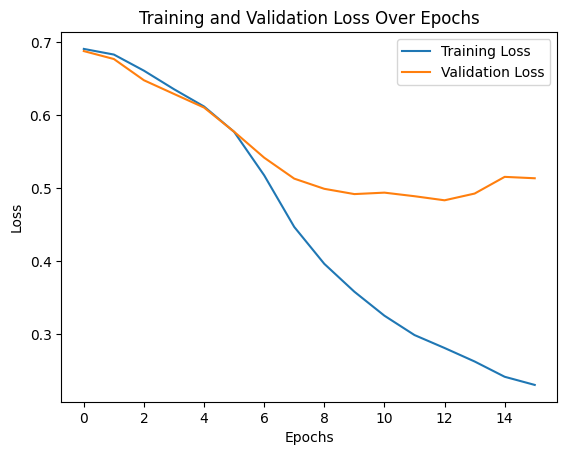

In [21]:
plot_histories(histories)

# Using Word2Vec

In [22]:
import gensim

word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('/kaggle/input/google-word2vec/GoogleNews-vectors-negative300.bin', binary=True)



In [23]:
word_index = tokenizer.word_index
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]



In [24]:
# Building the model
def build_word2vec_model(gru_units, dropout, lr):
    model = Sequential()
    model.add(Embedding(input_dim=len(word_index) + 1, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix],  # Pre-trained embeddings
                    trainable=False))
    
    model.add(GRU(gru_units, return_sequences=False))  # GRU layer
    model.add(Dropout(dropout))  # Dropout to prevent overfitting
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output layer

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [25]:
models = [
    build_word2vec_model(64, 0.1, 5e-5),
    build_word2vec_model(64, 0.5, 5e-5),
]

checkpoint_cb = [keras.callbacks.ModelCheckpoint(f"tweeter_model_{n}.keras", save_best_only=True) for n in range(len(models))]

early_stopping_cb = [keras.callbacks.EarlyStopping(
    patience=3, restore_best_weights=True
) for n in range(len(models))]


In [26]:
histories, best_accuracy, best_model = train_multiple_models(models)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5628 - loss: 0.6826 - val_accuracy: 0.6356 - val_loss: 0.6497
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6431 - loss: 0.6410 - val_accuracy: 0.6336 - val_loss: 0.6313
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6565 - loss: 0.6200 - val_accuracy: 0.6789 - val_loss: 0.6026
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6997 - loss: 0.5840 - val_accuracy: 0.7649 - val_loss: 0.5222
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7747 - loss: 0.4983 - val_accuracy: 0.7886 - val_loss: 0.4575
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7951 - loss: 0.4588 - val_accuracy: 0.7971 - val_loss: 0.4450
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8049 - loss: 0.4396 - val_accuracy: 0.8043 - val_loss: 0.4366
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7980 - loss: 0.4362 - val_accuracy: 0.

In [27]:
print(best_accuracy)

0.8260012865066528


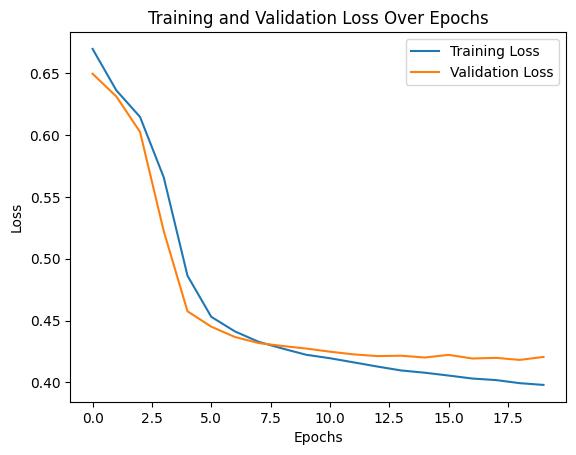

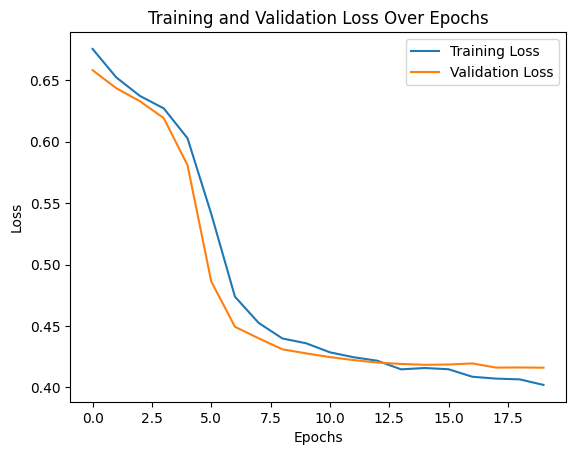

In [28]:
plot_histories(histories)

The results are much better when using word2vec! Let's attempt to scale up the model

In [29]:
models = [
    build_word2vec_model(128, 0.5, 1e-5),
    build_word2vec_model(512, 0.5, 1e-5),
    build_word2vec_model(1024, 0.5, 1e-5),
]

checkpoint_cb = [keras.callbacks.ModelCheckpoint(f"tweeter_model_{n}.keras", save_best_only=True) for n in range(len(models))]

early_stopping_cb = [keras.callbacks.EarlyStopping(
    patience=3, restore_best_weights=True
) for n in range(len(models))]


In [30]:
histories, best_accuracy, best_model = train_multiple_models(models)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5390 - loss: 0.6894 - val_accuracy: 0.5962 - val_loss: 0.6784
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5896 - loss: 0.6758 - val_accuracy: 0.6303 - val_loss: 0.6679
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6142 - loss: 0.6680 - val_accuracy: 0.6336 - val_loss: 0.6595
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6321 - loss: 0.6567 - val_accuracy: 0.6310 - val_loss: 0.6529
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6302 - loss: 0.6503 - val_accuracy: 0.6349 - val_loss: 0.6475
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6418 - loss: 0.6456 - val_accuracy: 0.6349 - val_loss: 0.6428
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6263 - loss: 0.6456 - val_accuracy: 0.6395 - val_loss: 0.6387
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6479 - loss: 0.6303 - val_accuracy: 0.

In [31]:
print(best_accuracy)

0.820748507976532


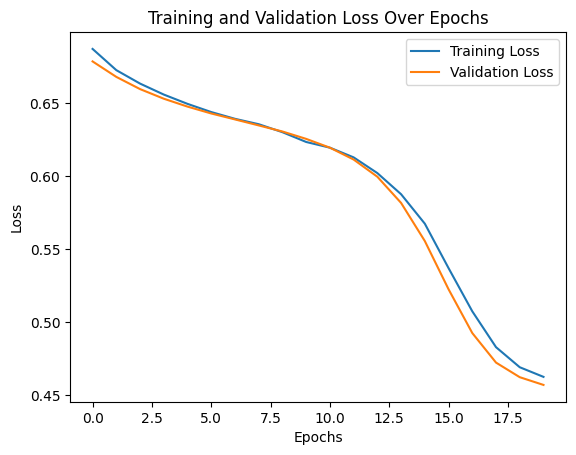

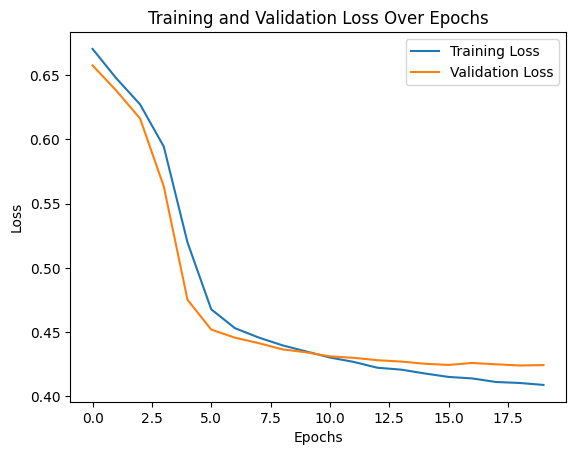

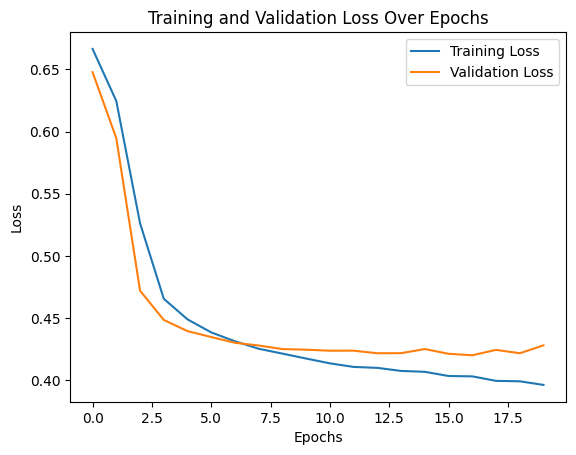

In [32]:
plot_histories(histories)

It does not seem like adding GRU units contribute much to the performances of the model, the best score stays similar although it converges faster.

# Submission

In [33]:
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [34]:

X = tokenizer.texts_to_sequences(test_df['text'])
X = pad_sequences(X)



In [35]:
best_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 31, 300)             │       6,810,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_7 (GRU)                          │ (None, 1024)                │       4,073,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,033,793 (72.61 MB)

 Trainable params: 4,074,497 (15.54 MB)

 Non-trainable params: 6,810,300 (25.98 MB)

 Optimizer params: 8,148,996 (31.09 MB)

In [36]:
pred_y = best_model.predict(X)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [37]:
test_df['target'] = 1*(pred_y>0.5)
test_df = test_df.set_index('id')
test_df = test_df[['target']]

In [38]:
test_df

,target
id,
0,0
2,1
3,1
9,1
11,1
...,...
10861,1
10865,1
10868,1


In [39]:
test_df.to_csv("submission.csv")

# Conclusions

In this project, I experimented with different GRU-based architectures and adjusted various hyperparameters to classify tweets as related to disasters or not.

I explored several configurations, varying the number of GRU units and dropout rates.

Initially, the performance was decent but not optimal. However, the most significant improvement came when I incorporated pre-trained Word2Vec embeddings.

By using these embeddings, which capture rich semantic relationships between words, the model was able to better understand the context of each tweet.

As a result, the model achieved a test accuracy of 82%, outperforming the previous attempts without pre-trained embeddings.

This demonstrates the effectiveness of Word2Vec in enhancing the performance of GRU-based models for text classification tasks, particularly when working with limited labeled data.